<a href="https://colab.research.google.com/github/monimoyd/S12/blob/master/S12_api.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment S12
In this assignment Resnet architecture is used to train Tiny Imagnet dataset and used Data Augmmentation. Developed APIs so as to load data, train, test and show results.

Following changes are done:

1. Added Data Augmentations (Albumentatons)
i. Cutout
ii. Horizontal Flip
iii. Padding
iv. Random Crop  


2. Added LRFinder to get good starting learning rate
3. Used ReduceLROnPlateau strategey for scheduling learning rates

Got best validation accuracy: 57.63%


In [0]:
%matplotlib inline
import autoreload
%load_ext autoreload
%autoreload

In [0]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-og5_kkc9
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-og5_kkc9
     |████████████████████████████████| 634kB 2.7MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65099 sha256=c1c1b4e7e0d4c5d593b8e6dec88e9cd5aa7e05c981440b64494eb84b84c15e1c
  Stored in directory: /tmp/pip-ephem-wheel-cache-gyqu83zt/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=9b54402f44c0677922a496d733698603197936ec2e604fcb77ea5a135a1d3a87
  Stored in directory: /tmp/pip-ephem-wheel-cache-gyqu83zt/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing installation: album

## Mount the google drive

In [0]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Copy all the API python files from the google drive to local folder

Follwing python files are imported from google drive. Purpsoe of these files are as below:

model.py - Defines the model class Net
train_test.py- API for training and testing
accuracy_utils - API foro getting test accuracy and per class accuracy
data_loader.py - API for loading train and test data
data_transform.py - API for transforming and normalizing data
plot_metrics.py - API for plotting metrics

In [0]:
!cp -rf '/content/drive/My Drive/eva_apis/data_loaders' .
!cp -rf '/content/drive/My Drive/eva_apis/data_transformations' .
!cp -rf '/content/drive/My Drive/eva_apis/models' .
!cp -rf '/content/drive/My Drive/eva_apis/utils' .

## Import all the libraries

In [0]:
from PIL import Image
import cv2
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from data_transformations.data_transform_tiny_imagenet_resnet import get_train_transform_64, get_train_transform_48, get_train_transform_32, get_test_transform
from data_loaders.tiny_imagenet_data_loader import perform_train_validation_split, get_classes,get_train_loader, get_test_loader
from models.resnet18 import ResNet18
from utils.train_test_utils import train,test
from utils.accuracy_utils import get_test_accuracy,get_accuracy_per_class
from utils.plot_metrics_utils import plot_accuracy
from utils.misclassified_image_utils import  display_misclassfied_ciphar10_images
import torchvision.datasets as datasets
import torch.utils.data as data
import os
import re





Training a Classifier
=====================



Training an image classifier
----------------------------

I have done the following steps in order:

1. Load and normalizing the Tiny Imagement training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data





 ## 1. Loading and normalizing Tiny Imagenet

 I have used APIs get_train_loader, get_test_loader to load train data and test data respectively. Both the APIs internally uses torchvision. I have used get_transform API to transform tensors in the range [-1,1]



In [0]:
!wget  http://cs231n.stanford.edu/tiny-imagenet-200.zip

--2020-04-18 10:45:52--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  20.4MB/s    in 14s     

2020-04-18 10:46:07 (16.4 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [0]:
!rm -rf tiny-imagenet-200
!unzip -qq tiny-imagenet-200.zip

## Perform 70:30 split between training and validation

In [0]:
perform_train_validation_split(	base_dir= './tiny-imagenet-200', validation_split = 0.3)

In [0]:
transform_train = get_train_transform_64()
transform_test = get_test_transform()


trainloader = get_train_loader('./tiny-imagenet-200', 256, transform_train)
testloader = get_test_loader('./tiny-imagenet-200',256, transform_test)


In [0]:
classes = get_classes('./tiny-imagenet-200')

## Visualizing some of the images in train dataset



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


n03085013 n01917289 n01644900 n04562935


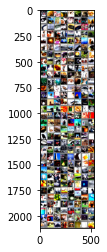

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolution Neural Network

I have defined the basic ResNet18 model and added dropout to it



In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model =  ResNet18(num_classes=200).to(device)
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
         Dropout2d-5           [-1, 64, 64, 64]               0
            Conv2d-6           [-1, 64, 64, 64]          36,864
       BatchNorm2d-7           [-1, 64, 64, 64]             128
         Dropout2d-8           [-1, 64, 64, 64]               0
        BasicBlock-9           [-1, 64, 64, 64]               0
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
        Dropout2d-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          36,864
      BatchNorm2d-14           [-1, 64,

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


## 3. Define a Loss function and optimizer and train the model

I have used Classification Cross-Entropy loss and SGD with learning rate 0.01 with momentum 0.9.

## 4. Train the model

 I have used 100 epochs to train the model

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []



In [0]:
!pip install torch-lr-finder

## Use LRFinder to find good starting learning rate

- First use exponetial step mode to find good learning rate range between 0.001 and 10
- Next use linear step mode to find good learning rate

In [0]:
!pip install torch-lr-finder

  pip install torch-lr-finder -v --global-option="amp"


/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)



Learning rate search finished. See the graph with {finder_name}.plot()


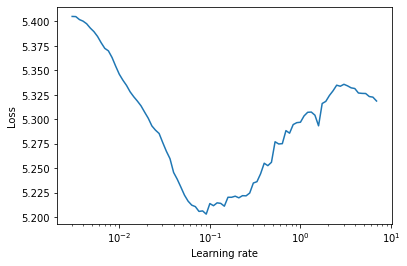

In [0]:
import torch.optim as optim
from torch_lr_finder import LRFinder

model =  ResNet18(num_classes=200).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=10, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)



Learning rate search finished. See the graph with {finder_name}.plot()


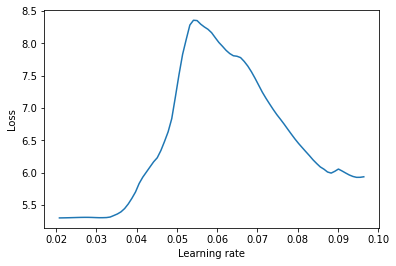

In [0]:
from torch_lr_finder import LRFinder

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, val_loader=testloader, end_lr=0.1, num_iter=100, step_mode="linear")
lr_finder.plot(log_lr=False)
lr_finder.reset()

## 3. Define a Loss function and optimizer and train the model

I have used Classification Cross-Entropy loss and SGD with learning rate 0.01 with momentum 0.9.

## 4. Train the model

 I have used 50 epochs to train the model

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

In [0]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import os

model =  ResNet18(num_classes=200).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9, weight_decay=0.0001)

EPOCHS = 50
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)


PATH = '/content/drive/My Drive/tiny_imagenet_api.pth'
torch.save(model.state_dict(), PATH)
best_test_accuracy = 0.0
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, trainloader, optimizer, epoch, train_losses,scheduler,train_acc)
    test(model, device, testloader, test_losses, test_acc)
    t_acc = test_acc[-1]
    if t_acc > best_test_accuracy:
        print("Test Accuracy: " + str(t_acc) + " has increased. Saving the model")
        best_test_accuracy = t_acc
        torch.save(model.state_dict(), PATH)
    
    scheduler.step(t_acc)

  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 0


/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 4.0998, Accuracy: 4122/33000 (12.49%)

Test Accuracy: 12.49090909090909 has increased. Saving the model
EPOCH: 1


Loss=3.395766019821167 Batch_id=300 Accuracy=17.06: 100%|██████████| 301/301 [02:40<00:00,  1.88it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 3.6514, Accuracy: 6112/33000 (18.52%)

Test Accuracy: 18.52121212121212 has increased. Saving the model
EPOCH: 2


Loss=3.1553375720977783 Batch_id=300 Accuracy=23.99: 100%|██████████| 301/301 [02:40<00:00,  1.88it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 3.6035, Accuracy: 6745/33000 (20.44%)

Test Accuracy: 20.439393939393938 has increased. Saving the model
EPOCH: 3


Loss=2.6533355712890625 Batch_id=300 Accuracy=29.83: 100%|██████████| 301/301 [02:40<00:00,  1.88it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 3.3887, Accuracy: 8460/33000 (25.64%)

Test Accuracy: 25.636363636363637 has increased. Saving the model
EPOCH: 4


Loss=2.826256036758423 Batch_id=300 Accuracy=34.42: 100%|██████████| 301/301 [02:40<00:00,  1.88it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 3.1200, Accuracy: 9509/33000 (28.82%)

Test Accuracy: 28.815151515151516 has increased. Saving the model
EPOCH: 5


Loss=2.6071584224700928 Batch_id=300 Accuracy=38.32: 100%|██████████| 301/301 [02:40<00:00,  1.88it/s]



Test set: Average loss: 3.0480, Accuracy: 10393/33000 (31.49%)

Test Accuracy: 31.493939393939392 has increased. Saving the model


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 6


Loss=2.54276704788208 Batch_id=300 Accuracy=41.74: 100%|██████████| 301/301 [02:40<00:00,  1.88it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 3.0162, Accuracy: 10630/33000 (32.21%)

Test Accuracy: 32.21212121212121 has increased. Saving the model
EPOCH: 7


Loss=2.2909600734710693 Batch_id=300 Accuracy=44.58: 100%|██████████| 301/301 [02:40<00:00,  1.88it/s]



Test set: Average loss: 2.6820, Accuracy: 12401/33000 (37.58%)

Test Accuracy: 37.57878787878788 has increased. Saving the model


  0%|          | 0/301 [00:00<?, ?it/s]

EPOCH: 8


Loss=2.0117502212524414 Batch_id=300 Accuracy=47.37: 100%|██████████| 301/301 [02:40<00:00,  1.88it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.4918, Accuracy: 13766/33000 (41.72%)

Test Accuracy: 41.71515151515152 has increased. Saving the model
EPOCH: 9


Loss=1.8194875717163086 Batch_id=300 Accuracy=49.80: 100%|██████████| 301/301 [02:40<00:00,  1.88it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.5589, Accuracy: 13467/33000 (40.81%)

EPOCH: 10


Loss=1.8340742588043213 Batch_id=300 Accuracy=52.11: 100%|██████████| 301/301 [02:40<00:00,  1.88it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.6692, Accuracy: 13209/33000 (40.03%)

EPOCH: 11


Loss=1.8309625387191772 Batch_id=300 Accuracy=54.52: 100%|██████████| 301/301 [02:40<00:00,  1.88it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.4857, Accuracy: 14140/33000 (42.85%)

Test Accuracy: 42.84848484848485 has increased. Saving the model
EPOCH: 12


Loss=1.7697503566741943 Batch_id=300 Accuracy=56.65: 100%|██████████| 301/301 [02:40<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.5061, Accuracy: 14246/33000 (43.17%)

Test Accuracy: 43.16969696969697 has increased. Saving the model
EPOCH: 13


Loss=1.572629451751709 Batch_id=300 Accuracy=58.56: 100%|██████████| 301/301 [02:40<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.3978, Accuracy: 14596/33000 (44.23%)

Test Accuracy: 44.23030303030303 has increased. Saving the model
EPOCH: 14


Loss=1.6023739576339722 Batch_id=300 Accuracy=60.48: 100%|██████████| 301/301 [02:40<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.4219, Accuracy: 14759/33000 (44.72%)

Test Accuracy: 44.724242424242426 has increased. Saving the model
EPOCH: 15


Loss=1.4915084838867188 Batch_id=300 Accuracy=62.91: 100%|██████████| 301/301 [02:40<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.4757, Accuracy: 14881/33000 (45.09%)

Test Accuracy: 45.093939393939394 has increased. Saving the model
EPOCH: 16


Loss=1.436549186706543 Batch_id=300 Accuracy=64.72: 100%|██████████| 301/301 [02:40<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.7204, Accuracy: 13915/33000 (42.17%)

EPOCH: 17


Loss=1.2038782835006714 Batch_id=300 Accuracy=66.75: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.2634, Accuracy: 15992/33000 (48.46%)

Test Accuracy: 48.46060606060606 has increased. Saving the model
EPOCH: 18


Loss=1.2667856216430664 Batch_id=300 Accuracy=68.61: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.2374, Accuracy: 16128/33000 (48.87%)

Test Accuracy: 48.872727272727275 has increased. Saving the model
EPOCH: 19


Loss=1.2075985670089722 Batch_id=300 Accuracy=70.98: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.4748, Accuracy: 15325/33000 (46.44%)

EPOCH: 20


Loss=0.9515381455421448 Batch_id=300 Accuracy=72.79: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.5206, Accuracy: 15713/33000 (47.62%)

EPOCH: 21


Loss=0.9224180579185486 Batch_id=300 Accuracy=74.84: 100%|██████████| 301/301 [02:40<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.2855, Accuracy: 16684/33000 (50.56%)

Test Accuracy: 50.557575757575755 has increased. Saving the model
EPOCH: 22


Loss=0.9565443992614746 Batch_id=300 Accuracy=76.93: 100%|██████████| 301/301 [02:40<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.5213, Accuracy: 15563/33000 (47.16%)

EPOCH: 23


Loss=0.7767124772071838 Batch_id=300 Accuracy=78.82: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.5366, Accuracy: 15877/33000 (48.11%)

EPOCH: 24


Loss=0.86639803647995 Batch_id=300 Accuracy=80.58: 100%|██████████| 301/301 [02:40<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.6409, Accuracy: 15714/33000 (47.62%)

EPOCH: 25


Loss=0.6751415729522705 Batch_id=300 Accuracy=82.57: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.5740, Accuracy: 16196/33000 (49.08%)

Epoch    26: reducing learning rate of group 0 to 3.0000e-03.
EPOCH: 26


Loss=0.29948121309280396 Batch_id=300 Accuracy=92.16: 100%|██████████| 301/301 [02:40<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0082, Accuracy: 18923/33000 (57.34%)

Test Accuracy: 57.342424242424244 has increased. Saving the model
EPOCH: 27


Loss=0.23654073476791382 Batch_id=300 Accuracy=94.74: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0061, Accuracy: 18880/33000 (57.21%)

EPOCH: 28


Loss=0.2394806295633316 Batch_id=300 Accuracy=95.55: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0118, Accuracy: 18952/33000 (57.43%)

Test Accuracy: 57.43030303030303 has increased. Saving the model
EPOCH: 29


Loss=0.20941688120365143 Batch_id=300 Accuracy=96.09: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0181, Accuracy: 18960/33000 (57.45%)

Test Accuracy: 57.45454545454545 has increased. Saving the model
EPOCH: 30


Loss=0.23883403837680817 Batch_id=300 Accuracy=96.46: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0225, Accuracy: 18926/33000 (57.35%)

EPOCH: 31


Loss=0.18699483573436737 Batch_id=300 Accuracy=96.81: 100%|██████████| 301/301 [02:40<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0294, Accuracy: 18957/33000 (57.45%)

EPOCH: 32


Loss=0.1887464076280594 Batch_id=300 Accuracy=97.09: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0413, Accuracy: 18920/33000 (57.33%)

EPOCH: 33


Loss=0.18676960468292236 Batch_id=300 Accuracy=97.26: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0494, Accuracy: 18917/33000 (57.32%)

Epoch    34: reducing learning rate of group 0 to 3.0000e-04.
EPOCH: 34


Loss=0.17679676413536072 Batch_id=300 Accuracy=97.60: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0413, Accuracy: 18965/33000 (57.47%)

Test Accuracy: 57.46969696969697 has increased. Saving the model
EPOCH: 35


Loss=0.1456754356622696 Batch_id=300 Accuracy=97.61: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0409, Accuracy: 18952/33000 (57.43%)

EPOCH: 36


Loss=0.14365851879119873 Batch_id=300 Accuracy=97.75: 100%|██████████| 301/301 [02:40<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0431, Accuracy: 18965/33000 (57.47%)

EPOCH: 37


Loss=0.1653047800064087 Batch_id=300 Accuracy=97.74: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0413, Accuracy: 19000/33000 (57.58%)

Test Accuracy: 57.57575757575758 has increased. Saving the model
EPOCH: 38


Loss=0.1710677146911621 Batch_id=300 Accuracy=97.89: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0397, Accuracy: 19013/33000 (57.62%)

Test Accuracy: 57.61515151515152 has increased. Saving the model
EPOCH: 39


Loss=0.16321639716625214 Batch_id=300 Accuracy=97.69: 100%|██████████| 301/301 [02:40<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0442, Accuracy: 18980/33000 (57.52%)

EPOCH: 40


Loss=0.22983628511428833 Batch_id=300 Accuracy=97.84: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0477, Accuracy: 19018/33000 (57.63%)

Test Accuracy: 57.63030303030303 has increased. Saving the model
EPOCH: 41


Loss=0.13034731149673462 Batch_id=300 Accuracy=97.86: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0431, Accuracy: 18998/33000 (57.57%)

EPOCH: 42


Loss=0.12656143307685852 Batch_id=300 Accuracy=97.79: 100%|██████████| 301/301 [02:40<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0465, Accuracy: 19004/33000 (57.59%)

EPOCH: 43


Loss=0.18834079802036285 Batch_id=300 Accuracy=97.89: 100%|██████████| 301/301 [02:40<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0494, Accuracy: 18998/33000 (57.57%)

EPOCH: 44


Loss=0.16565436124801636 Batch_id=300 Accuracy=97.82: 100%|██████████| 301/301 [02:40<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0507, Accuracy: 18959/33000 (57.45%)

Epoch    45: reducing learning rate of group 0 to 3.0000e-05.
EPOCH: 45


Loss=0.11036140471696854 Batch_id=300 Accuracy=97.90: 100%|██████████| 301/301 [02:40<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0483, Accuracy: 18986/33000 (57.53%)

EPOCH: 46


Loss=0.09492652863264084 Batch_id=300 Accuracy=97.94: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0510, Accuracy: 18981/33000 (57.52%)

EPOCH: 47


Loss=0.15976817905902863 Batch_id=300 Accuracy=97.94: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0460, Accuracy: 18993/33000 (57.55%)

EPOCH: 48


Loss=0.15874356031417847 Batch_id=300 Accuracy=97.92: 100%|██████████| 301/301 [02:41<00:00,  1.87it/s]
  0%|          | 0/301 [00:00<?, ?it/s]


Test set: Average loss: 2.0475, Accuracy: 18977/33000 (57.51%)

Epoch    49: reducing learning rate of group 0 to 3.0000e-06.
EPOCH: 49


Loss=0.13912276923656464 Batch_id=300 Accuracy=97.87: 100%|██████████| 301/301 [02:40<00:00,  1.87it/s]



Test set: Average loss: 2.0446, Accuracy: 18988/33000 (57.54%)



## Load the Best Model

In [0]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

## 5. Test the network on the test data 


In this step
- A few actual images are shown with label.
- Next print the test accuracy using API get_test_accuracy
- Next diplay class level accuracy using API get_accuracy_per_class which will give idea about which all classes prediction was good and which all classes prediction was not that good



GroundTruth:  n01443537 n01443537 n01443537 n01443537


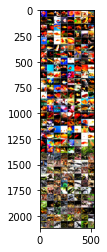

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [0]:
with torch.no_grad():
    images, labels = images.to(device), labels.to(device)
    outputs = model(images) 

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [0]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  n01443537 n01443537 n01443537 n01443537


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [0]:
print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    get_test_accuracy(model, testloader, device)))

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Accuracy of the network on the 10000 test images: 57.63 %




```
`# This is formatted as code`
```

The accuracy 57.63 is far better than chance, which is 10% accuracy (randomly picking a class out of 10 classes).
Seems like the network learnt good.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [0]:
class_correct,class_total = get_accuracy_per_class(model, testloader, device, num_classes=len(classes))

for i in range(len(classes)):
    if class_total[i] > 0.0:
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

/content/models/resnet18.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(out)


Accuracy of n01443537 : 100 %
Accuracy of n01629819 : 50 %
Accuracy of n01644900 : 50 %
Accuracy of n01698640 : 50 %
Accuracy of n01768244 : 75 %
Accuracy of n01770393 : 25 %
Accuracy of n01774750 : 100 %
Accuracy of n01784675 : 50 %
Accuracy of n01882714 : 50 %
Accuracy of n01910747 : 75 %
Accuracy of n01944390 : 50 %
Accuracy of n01950731 : 25 %
Accuracy of n01983481 : 75 %
Accuracy of n02002724 : 25 %
Accuracy of n02056570 : 100 %
Accuracy of n02074367 : 100 %
Accuracy of n02085620 : 50 %
Accuracy of n02099601 : 50 %
Accuracy of n02099712 : 75 %
Accuracy of n02113799 : 50 %
Accuracy of n02123394 : 50 %
Accuracy of n02124075 :  0 %
Accuracy of n02129165 : 75 %
Accuracy of n02132136 : 100 %
Accuracy of n02190166 : 75 %
Accuracy of n02206856 : 75 %
Accuracy of n02231487 : 25 %
Accuracy of n02233338 : 25 %
Accuracy of n02268443 : 50 %
Accuracy of n02279972 : 100 %
Accuracy of n02281406 : 100 %
Accuracy of n02321529 : 25 %
Accuracy of n02395406 : 25 %
Accuracy of n02403003 : 25 %
Accurac

## Plot the performance metrics

In this step, the following metrics are plotted

i. Training Accuracy
ii. Test Accuracy

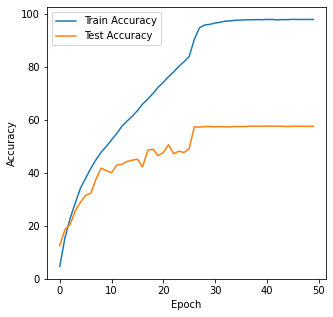

In [0]:
def plot_accuracy(train_acc, test_acc):	
    fig, axs = plt.subplots(figsize=(5,5))
    axs.plot(train_acc, label="Train Accuracy")
    axs.plot(test_acc, label="Test Accuracy")
    axs.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()
plot_accuracy(train_acc, test_acc)
